# Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [2]:
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)

In [3]:
print(torch.__version__)
print("CUDA Available:", torch.cuda.is_available())

2.7.1+cu118
CUDA Available: True


# Load Preprocessed Data

In [5]:
DATA_PATH = '../data/processed_loans.csv'
df = pd.read_csv(DATA_PATH)

print(f"Data Loaded. Shape: {df.shape}")

Data Loaded. Shape: (176083, 80)


# Seprating Features & Target: X, y

In [6]:
X = df.drop(columns=['target'])
y = df['target']

print(f"Features: {X.shape[1]}")
print(f"Target:\n{y.value_counts(normalize=True)}")

Features: 79
Target:
target
0    0.800713
1    0.199287
Name: proportion, dtype: float64


# Splitting the Train & Test data

<p>Train (70%): The model learns from this. <br>
Validation (15%): We use this to check performance DURING training (Early Stopping). <br>
Test (15%): We lock this away until the very end to calculate AUC/F1.</p>

In [7]:
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.30, random_state=SEED, stratify=y
)

In [8]:
# Splitting for validation and test sets
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=SEED, stratify=y_temp
)

In [10]:
print(f"Train Set: {X_train.shape} | {y_train.mean():.2%}")
print(f"Val Set:   {X_val.shape}   | {y_val.mean():.2%}")
print(f"Test Set:  {X_test.shape}  | {y_test.mean():.2%}")

Train Set: (123258, 79) | 19.93%
Val Set:   (26412, 79)   | 19.93%
Test Set:  (26413, 79)  | 19.93%


# Scaling & Tensoring the Data

## Scaling

In [11]:
scaler = StandardScaler()

In [12]:
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

## Tensoring

In [14]:
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).unsqueeze(1) 

X_val_tensor = torch.tensor(X_val_scaled, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32).unsqueeze(1)

X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).unsqueeze(1)

In [15]:
print(f"X_train_tensor shape: {X_train_tensor.shape}")
print(f"y_train_tensor shape: {y_train_tensor.shape}")

X_train_tensor shape: torch.Size([123258, 79])
y_train_tensor shape: torch.Size([123258, 1])


# Moving data to GPU for Fast Training

In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using Device: {device}")

Using Device: cuda


In [17]:
X_train_tensor = X_train_tensor.to(device)
y_train_tensor = y_train_tensor.to(device)
X_val_tensor = X_val_tensor.to(device)
y_val_tensor = y_val_tensor.to(device)
X_test_tensor = X_test_tensor.to(device)
y_test_tensor = y_test_tensor.to(device)

# Defining the DL model architecture

In [19]:
import torch.nn as nn
import torch.optim as optim

## Model Architecure

<p>The Architecture Strategy:<br>
Input Size: 79. <br>
Hidden Layers: "Funnel" shape (256 -> 128 -> 64). This compresses the information, forcing the model to learn the most important patterns.<br>
Dropout (0.3): During training, randomly "turn off" 30% of the neurons. Drop out prevents overfitting. <br>
Sigmoid Output: final result between 0 and 1, giving us a probability.</p>

In [ ]:
class LoanDefaultModel(nn.Module):
    def __init__(self, input_size):
        super(LoanDefaultModel, self).__init__()
        
        # Layer 1: Input to 256 neurons
        self.layer1 = nn.Linear(input_size, 256)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.3)
        
        # Layer 2: 256 to 128 neurons
        self.layer2 = nn.Linear(256, 128)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.3)
        
        # Layer 3: 128 to 64 neurons
        self.layer3 = nn.Linear(128, 64)
        self.relu3 = nn.ReLU()
        self.dropout3 = nn.Dropout(0.3)
        
        # Output Layer: 64 to 1 neuron (Binary Prediction)
        self.output = nn.Linear(64, 1)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        # Pass data through layer 1
        x = self.layer1(x)
        x = self.relu1(x)
        x = self.dropout1(x)
        
        # Pass data through layer 2
        x = self.layer2(x)
        x = self.relu2(x)
        x = self.dropout2(x)
        
        # Pass data through layer 3
        x = self.layer3(x)
        x = self.relu3(x)
        x = self.dropout3(x)
        
        # Output probability
        x = self.output(x)
        x = self.sigmoid(x)
        return x

## Model Initialization

In [28]:
input_features = X_train.shape[1] # 79
model = LoanDefaultModel(input_features)

# Move model to GPU
model = model.to(device)

print(model)

LoanDefaultModel(
  (layer1): Linear(in_features=79, out_features=256, bias=True)
  (relu1): ReLU()
  (dropout1): Dropout(p=0.3, inplace=False)
  (layer2): Linear(in_features=256, out_features=128, bias=True)
  (relu2): ReLU()
  (dropout2): Dropout(p=0.3, inplace=False)
  (layer3): Linear(in_features=128, out_features=64, bias=True)
  (relu3): ReLU()
  (dropout3): Dropout(p=0.3, inplace=False)
  (output): Linear(in_features=64, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


## Loss & Optimizer

In [29]:
criterion = nn.BCELoss() # Binary Cross Entropy loss
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Model Training

In [32]:
epochs = 50
train_losses = []
val_losses = []

## Training loop

In [33]:
for epoch in range(epochs):
    # 1. Training Phase
    model.train() # Enable Dropout
    optimizer.zero_grad() # Clear previous gradients
    
    # Forward pass
    y_pred = model(X_train_tensor)
    loss = criterion(y_pred, y_train_tensor)
    
    # Backward pass and optimization
    loss.backward()
    optimizer.step()
    
    # 2. Validation Phase
    model.eval() # Disable Dropout for accurate metrics
    with torch.no_grad():
        y_val_pred = model(X_val_tensor)
        val_loss = criterion(y_val_pred, y_val_tensor)
    
    # Store history
    train_losses.append(loss.item())
    val_losses.append(val_loss.item())
    
    # Print progress every 5 epochs
    if (epoch + 1) % 5 == 0:
        print(f"Epoch {epoch+1}/{epochs} | Train Loss: {loss.item():.4f} | Val Loss: {val_loss.item():.4f}")

print("Training Complete.")

Epoch 5/50 | Train Loss: 0.4686 | Val Loss: 0.4624
Epoch 10/50 | Train Loss: 0.4610 | Val Loss: 0.4548
Epoch 15/50 | Train Loss: 0.4544 | Val Loss: 0.4500
Epoch 20/50 | Train Loss: 0.4512 | Val Loss: 0.4474
Epoch 25/50 | Train Loss: 0.4485 | Val Loss: 0.4456
Epoch 30/50 | Train Loss: 0.4469 | Val Loss: 0.4444
Epoch 35/50 | Train Loss: 0.4454 | Val Loss: 0.4432
Epoch 40/50 | Train Loss: 0.4436 | Val Loss: 0.4421
Epoch 45/50 | Train Loss: 0.4429 | Val Loss: 0.4414
Epoch 50/50 | Train Loss: 0.4420 | Val Loss: 0.4406
Training Complete.


## Plotting the Loss curve

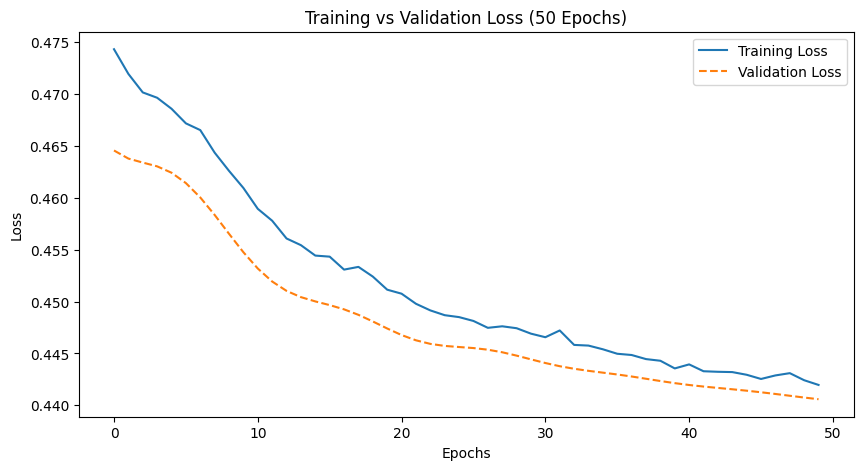

In [34]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss', linestyle='--')
plt.title('Training vs Validation Loss (50 Epochs)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Final Model Evaluation on Test Set

In [35]:
from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix, classification_report, roc_curve

In [36]:
model.eval() 
with torch.no_grad():
    # Get raw probabilities (0.0 to 1.0)
    y_test_pred_prob = model(X_test_tensor)
    
    # Move back to CPU for Scikit-Learn
    y_test_prob_numpy = y_test_pred_prob.cpu().numpy()
    y_test_true_numpy = y_test_tensor.cpu().numpy()

In [37]:
# Convert probabilities to Binary Predictions (0 or 1) with a threshold of 0.5
y_test_pred_class = (y_test_prob_numpy > 0.5).astype(int)

## Calculating the Metrics

In [38]:
auc = roc_auc_score(y_test_true_numpy, y_test_prob_numpy)
f1 = f1_score(y_test_true_numpy, y_test_pred_class)

In [39]:
print(f"Final Test AUC: {auc:.4f}")
print(f"Final Test F1-Score: {f1:.4f}")
print("-" * 30)
print("Confusion Matrix:\n", confusion_matrix(y_test_true_numpy, y_test_pred_class))
print("\nClassification Report:\n", classification_report(y_test_true_numpy, y_test_pred_class))

Final Test AUC: 0.7412
Final Test F1-Score: 0.0011
------------------------------
Confusion Matrix:
 [[21147     2]
 [ 5261     3]]

Classification Report:
               precision    recall  f1-score   support

         0.0       0.80      1.00      0.89     21149
         1.0       0.60      0.00      0.00      5264

    accuracy                           0.80     26413
   macro avg       0.70      0.50      0.45     26413
weighted avg       0.76      0.80      0.71     26413



## ROC Curve

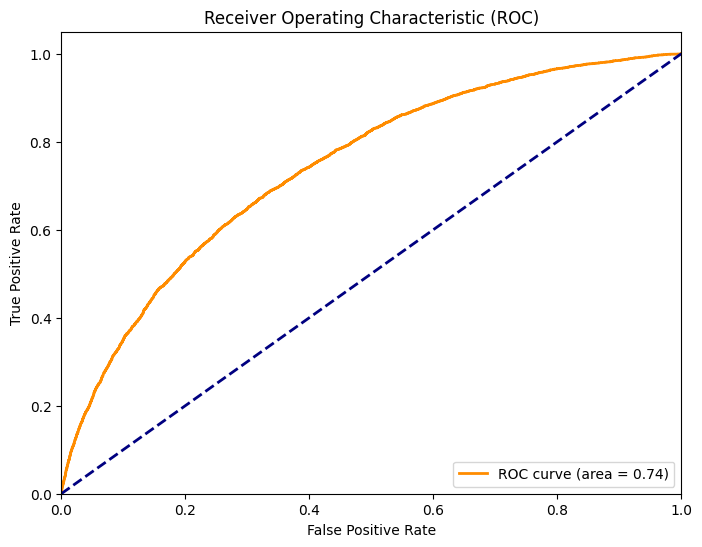

In [40]:
fpr, tpr, thresholds = roc_curve(y_test_true_numpy, y_test_prob_numpy)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()